<a href="https://colab.research.google.com/github/tugcegurbuz/PLENA24-Learning-in-Artificial-Neural-Networks/blob/main/tutorials/2_Intro_to_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Introduction to Convolutional Neural Networks

By [Tugce Gurbuz ](https://tugcegurbuz.github.io)as a part of [PLENA-2024](https://plena.cenia.cl) Learning in Artificial Neural Networks workshop

**Reference:** Adapted from [Neuromatch Academy - Deep Learning Summer School](https://deeplearning.neuromatch.io/tutorials/intro.html) - [W2D2 materials](https://deeplearning.neuromatch.io/tutorials/W2D2_ConvnetsAndDlThinking/chapter_title.html)

---
# Tutorial Objectives
At the end of this tutorial, we will be able to:
- Define what convolution is
- Implement convolution as an operation
- Train a CNN for classification of clothes



---
# Setup

In [15]:
# Imports
import os
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import requests
import tqdm
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image

In [16]:
# @title Figure Settings
import ipywidgets as widgets       # Interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [59]:
# @title Helper functions
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


# Just returns accuracy on test data


In [38]:
# @title Plotting Functions

def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

In [19]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [20]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [21]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


---
# Section 1: Convolutions and Edge Detection

Let's take a look at convolution operation again through our interactive demo!

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/correlation.svg">

Adopted from A. Zhang, Z. C. Lipton, M. Li and A. J. Smola, _[Dive into Deep Learning](http://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html)_.

<br>

**Note:** You need to run the cell to activate the sliders, and again to run once changing the sliders.

**Tip:** In this animation, and all the ones that follow, you can hover over the parts of the code underlined in red to change them.

**Tip:** Below, the function is called `Conv2d` because the convolutional filter is a matrix with two dimensions (2D).  There are also 1D and 3D convolutions, but we won't talk about them today.

### Interactive Demo 1: Visualization of Convolution

**Important:** Change the bool variable `run_demo` to `True` by ticking the box, in order to experiment with the demo. Due to video rendering on jupyter-book, we had to remove it from the automatic execution.

In [8]:
# @markdown *Run this cell to enable the widget!*

from IPython.display import HTML

id_html = 2
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True  # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

## Section 1.1: Training a Convolutional Neural Network in PyTorch
In the following cell, we provide a code snippet that demonstrates setting up a convolutional network using PyTorch.

We look at the `nn` module in PyTorch. The `nn` module contains a plethora of functions that will make implementing a neural network easier. In particular we will look at the `nn.Conv2d()` function, which creates a convolutional layer that is applied to whatever image that you feed the resulting network.

Let's look at the code below.

In [9]:
class CNN_1(nn.Module):
  """
  A convolutional neural network class.
  When an instance of it is constructed with a kernel, you can apply that instance
    to a matrix and it will convolve the kernel over that image.
  i.e. Net(kernel)(image)
  """

  def __init__(self, kernel=None, padding=0):
    super(CNN_1, self).__init__()
    """
    Summary of the nn.conv2d parameters (you can also get this by hovering
    over the method):
    - in_channels (int): Number of channels in the input image
    - out_channels (int): Number of channels produced by the convolution
    - kernel_size (int or tuple): Size of the convolving kernel

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      kernel: np.ndarray
        Convolving kernel. Default: None

    Returns:
      Nothing
    """
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2,
                           padding=padding)

    # Set up a default kernel if a default one isn't provided
    if kernel is not None:
      dim1, dim2 = kernel.shape[0], kernel.shape[1]
      kernel = kernel.reshape(1, 1, dim1, dim2)

      self.conv1.weight = torch.nn.Parameter(kernel)
      self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias)) # torch.zeros_like
                                        #returns a tensor filled with the scalar value 0, with the
                                        #same size as input

  def forward(self, x):
    """
    Forward Pass of nn.conv2d

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    return x

In [10]:
# Format a default 2x2 kernel of numbers from 0 through 3
kernel = torch.Tensor(np.arange(4).reshape(2, 2))

# Prepare the network with that default kernel
net = CNN_1(kernel=kernel, padding=0).to(DEVICE)

# Set up a 3x3 image matrix of numbers from 0 through 8
image = torch.Tensor(np.arange(9).reshape(3, 3))
image = image.reshape(1, 1, 3, 3).to(DEVICE)  # BatchSize X Channels X Height X Width

print("Image:\n" + str(image))
print("Kernel:\n" + str(kernel))
output = net(image)  # Apply the convolution
print("Output:\n" + str(output))

Image:
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[19., 25.],
          [37., 43.]]]], grad_fn=<ConvolutionBackward0>)


As a quick aside, notice the difference in the input and output size. The input had a size of 3×3, and the output is of size 2×2. This is because of the fact that the kernel can't produce values for the edges of the image - when it slides to an end of the image and is centered on a border pixel, it overlaps space outside of the image that is undefined. If we don't want to lose that information, we will have to pad the image with some defaults (such as 0s) on the border. This process is, somewhat predictably, called *padding*. We will talk more about padding in the next section.

In [11]:
print("Image (before padding):\n" + str(image))
print("Kernel:\n" + str(kernel))

# Prepare the network with the aforementioned default kernel, but this
# time with padding
net = CNN_1(kernel=kernel, padding=1).to(DEVICE)
output = net(image)  # Apply the convolution onto the padded image
print("Output:\n" + str(output))

Image (before padding):
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]], grad_fn=<ConvolutionBackward0>)


## Section 1.2: Padding

Before we start in on the exercises, here's a visualization to help you think about padding.

### Interactive Demo 2.2: Visualization of Convolution with Padding and Stride


Recall that
* Padding adds rows and columns of zeros to the outside edge of an image
* Stride length adjusts the distance by which a filter is shifted after each convolution.

Change the padding and stride and see how this affects the shape of the output. How does the padding need to be configured to maintain the shape of the input?

In [12]:
# @markdown *Run this cell to enable the widget!*

from IPython.display import HTML

id_html = 2.2
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

---
# Section 2: Pooling and Subsampling

To visualize the various components of a CNN, we will build a simple CNN step by step. Recall that the MNIST dataset consists of binarized images of handwritten digits. This time, we will use the Fashion MNIST dataset, which consists of binarized images of clothes.

We will simplify the problem further by only keeping the images from 2 classes.

In [22]:
# @title Download Fashion MNIST dataset

# webpage: https://github.com/zalandoresearch/fashion-mnist
fname = 'FashionMNIST.tar.gz'
folder = 'FashionMNIST'
url = "https://osf.io/dfhu5/download"
download_data(fname, folder, url, tar=True)

FashionMNIST dataset has already been downloaded.



In [23]:
# @title Loading Fashion-MNIST Data

# @markdown `reduce_classes(data)` to reduce Fashion-MNIST Data to two-categories

# need to split into train, validation, test
def reduce_classes(data):
  """
  Reducing classes in Fashion MNIST
  to T-Shirts and Shirts

  Args:
    data: torch.tensor
      Training Data

  Returns:
    data: torch.tensor
      Data with two classes
  """
  # Only want T-Shirts (0) and Shirts (6) labels
  train_idx = (data.targets == 0) | (data.targets == 6)
  data.targets = data.targets[train_idx]
  data.data = data.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  data.targets[data.targets == 6] = 1

  return data


def get_fashion_mnist_dataset(binary=False, download=False, seed=0):
  """
  Helper function to get Fashion MNIST data

  Args:
    binary: boolean
      If True, training data has only two classes
    download: boolean
      If True, download training data
    seed: int
      Set seed for reproducibility [default: 0]

  Returns:
    train_data: torch.tensor
      Training data
    test_data: torch.tensor
      Test data
    validation_data: torch.tensor
      Validation data
  """
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                                  ])

  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=transform)


  test_data = datasets.FashionMNIST(root='.',
                                    download=download,
                                    train=False,
                                    transform=transform)

  if binary:
    train_data = reduce_classes(train_data)
    test_data = reduce_classes(test_data)

  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                             [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data

In [24]:
num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, seed=SEED)

Random seed 42 has been set.


Here's some code to visualize the dataset.

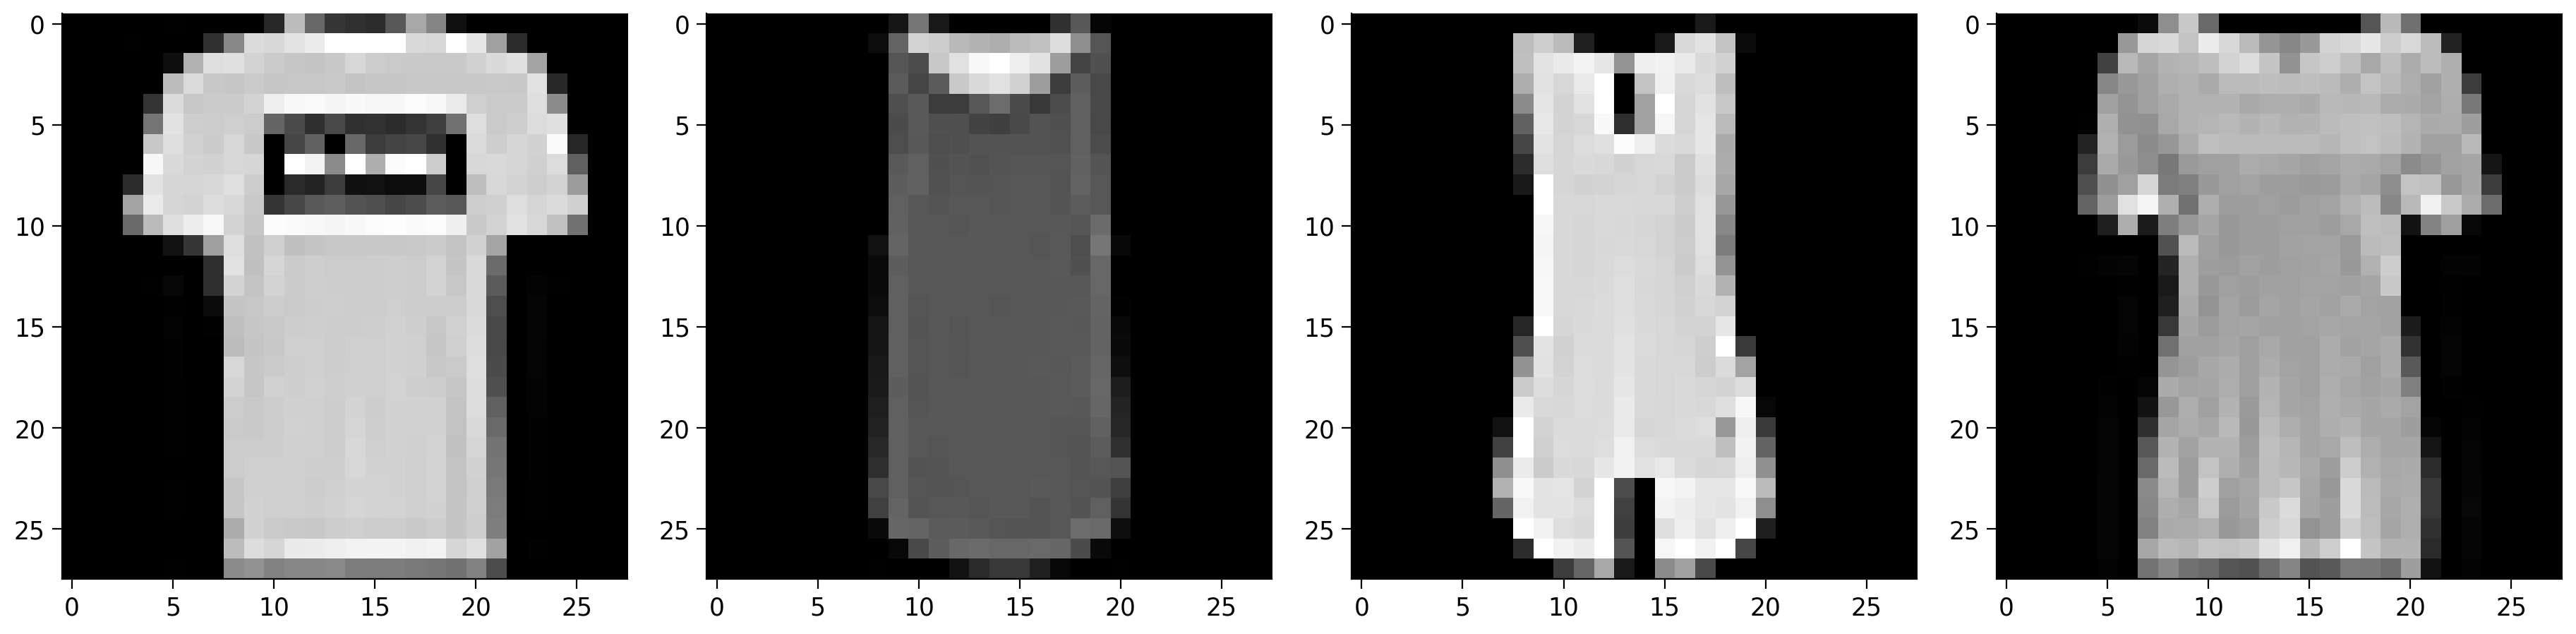

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

## Interactive Demo 3: Visualization of Convolution with Multiple Filters

Change the number of input channels (e.g., the color channels of an image or the output channels of a previous layer) and the output channels (number of different filters to apply).

**Important:** Change the bool variable `run_demo` to `True` by ticking the box, in order to experiment with the demo. Due to video rendering on jupyter-book, we had to remove it from the automatic execution.

In [40]:
# @markdown *Run this cell to enable the widget!*

from IPython.display import HTML

id_html = 3
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

## Section 3.1: Multiple Filters

The following network sets up 3 filters and runs them on an image of the dataset.

In [50]:
class Net2(nn.Module):
  """
  Neural Network instance
  """

  def __init__(self, padding=0):
    """
    Initialize parameters of Net2

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0

    Returns:
      Nothing
    """
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel - THINK! leading ... pattern
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - THINK! leading ... pattern
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # tThird kernel - THINK! leading ... pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net2

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    return x

**Note:** We add a negative bias to give a threshold to select the high output value, which corresponds to the features we want to detect (e.g., 45 degree oriented bar).

Now, let's visualize the filters using the code given below.

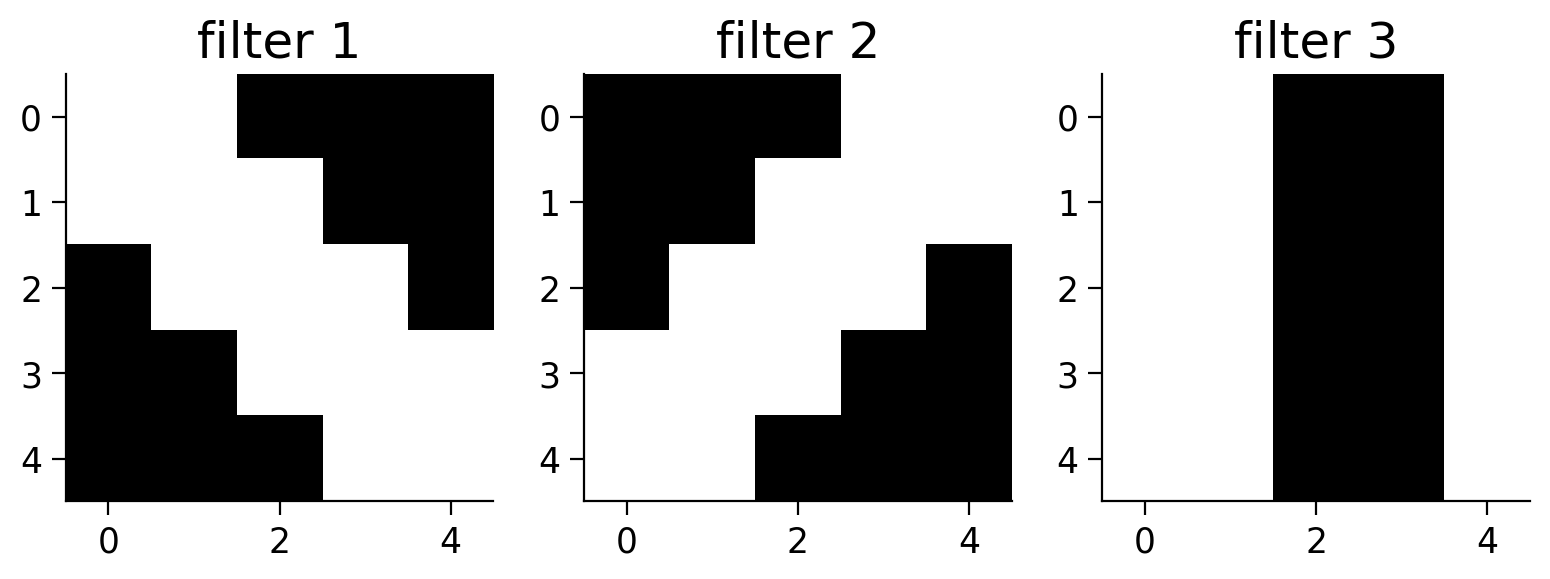

In [51]:
net2 = Net2().to(DEVICE)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3)
# Show the filters
ax11.set_title("filter 1")
ax11.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax12.set_title("filter 2")
ax12.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 3")
ax13.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

We apply the filters to the images.

In [52]:
net2 = Net2().to(DEVICE)
x_img = train_data[0][0].unsqueeze(dim=0).to(DEVICE)
output_x = net2(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = train_data[1][0].unsqueeze(dim=0).to(DEVICE)
output_o = net2(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

Let us view the image of tshirt and dress and what the output of the filters applied to them looks like. Pay special attention to the areas with very high vs. very low output patterns.

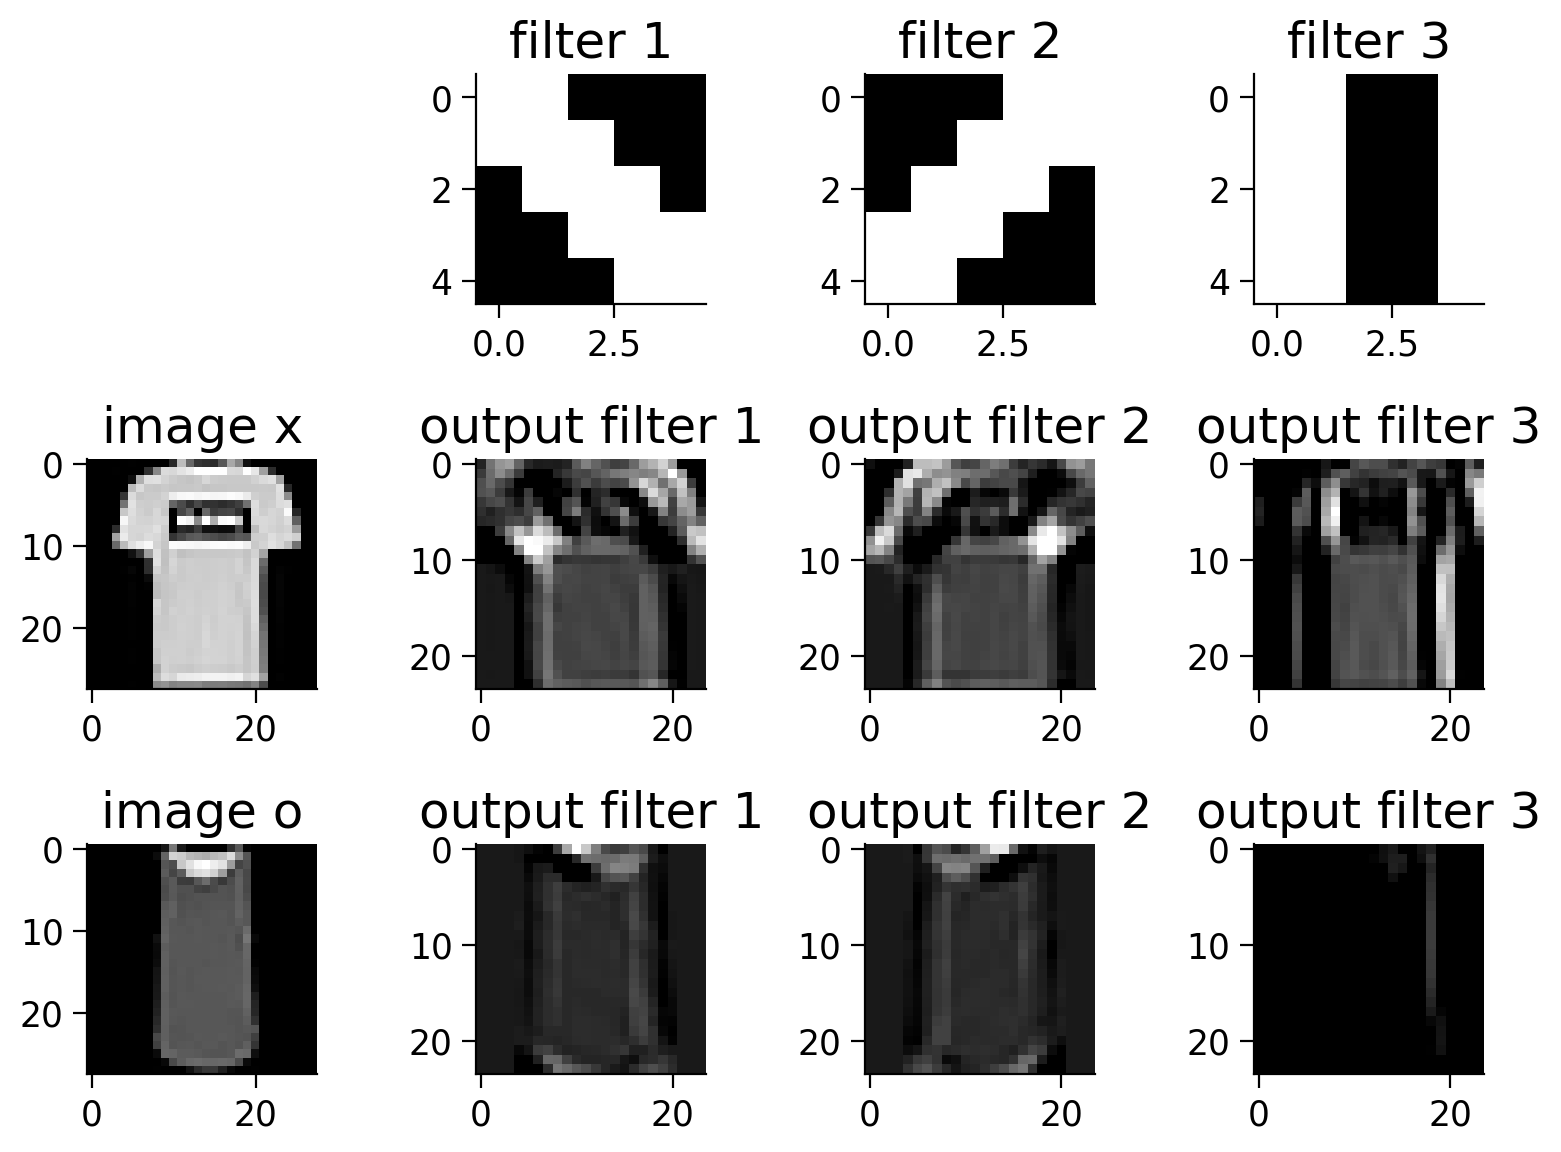

In [53]:
fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show tshirt and the filters applied to
ax21.set_title("image x")
ax21.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show dress and the filters applied to
ax31.set_title("image o")
ax31.imshow(train_data[1][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

## Section 2.2: ReLU after convolutions

Up until now we've talked about the convolution operation, which is linear. But the real strength of neural networks comes from the incorporation of non-linear functions.  Furthermore, in the real world, we often have learning problems where the relationship between the input and output is non-linear and complex.

The ReLU (Rectified Linear Unit) introduces non-linearity into our model, allowing us to learn a more complex function that can better predict the class of an image.

The ReLU function is shown below.

<br>

<figure>
  <center><img src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/relu.png width=400px>
  <figcaption>The Rectified Linear Unit (ReLU) Activation Function<figcaption>
  </center>
</figure>

Now let us incorporate ReLU into our previous model and visualize the output.

In [54]:
class Net3(nn.Module):
  """
  Neural Network Instance
  """

  def __init__(self, padding=0):
    """
    Initialize Net3 parameters

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0

    Returns:
      Nothing
    """
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net3

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    x = F.relu(x)
    return x

We apply the filters and relus to the images.

In [55]:
net3 = Net3().to(DEVICE)
x_img = train_data[0][0].unsqueeze(dim=0).to(DEVICE)
output_x_relu = net3(x_img)
output_x_relu = output_x_relu.squeeze(dim=0).detach().cpu().numpy()

o_img = train_data[1][0].unsqueeze(dim=0).to(DEVICE)
output_o_relu = net3(o_img)
output_o_relu = output_o_relu.squeeze(dim=0).detach().cpu().numpy()

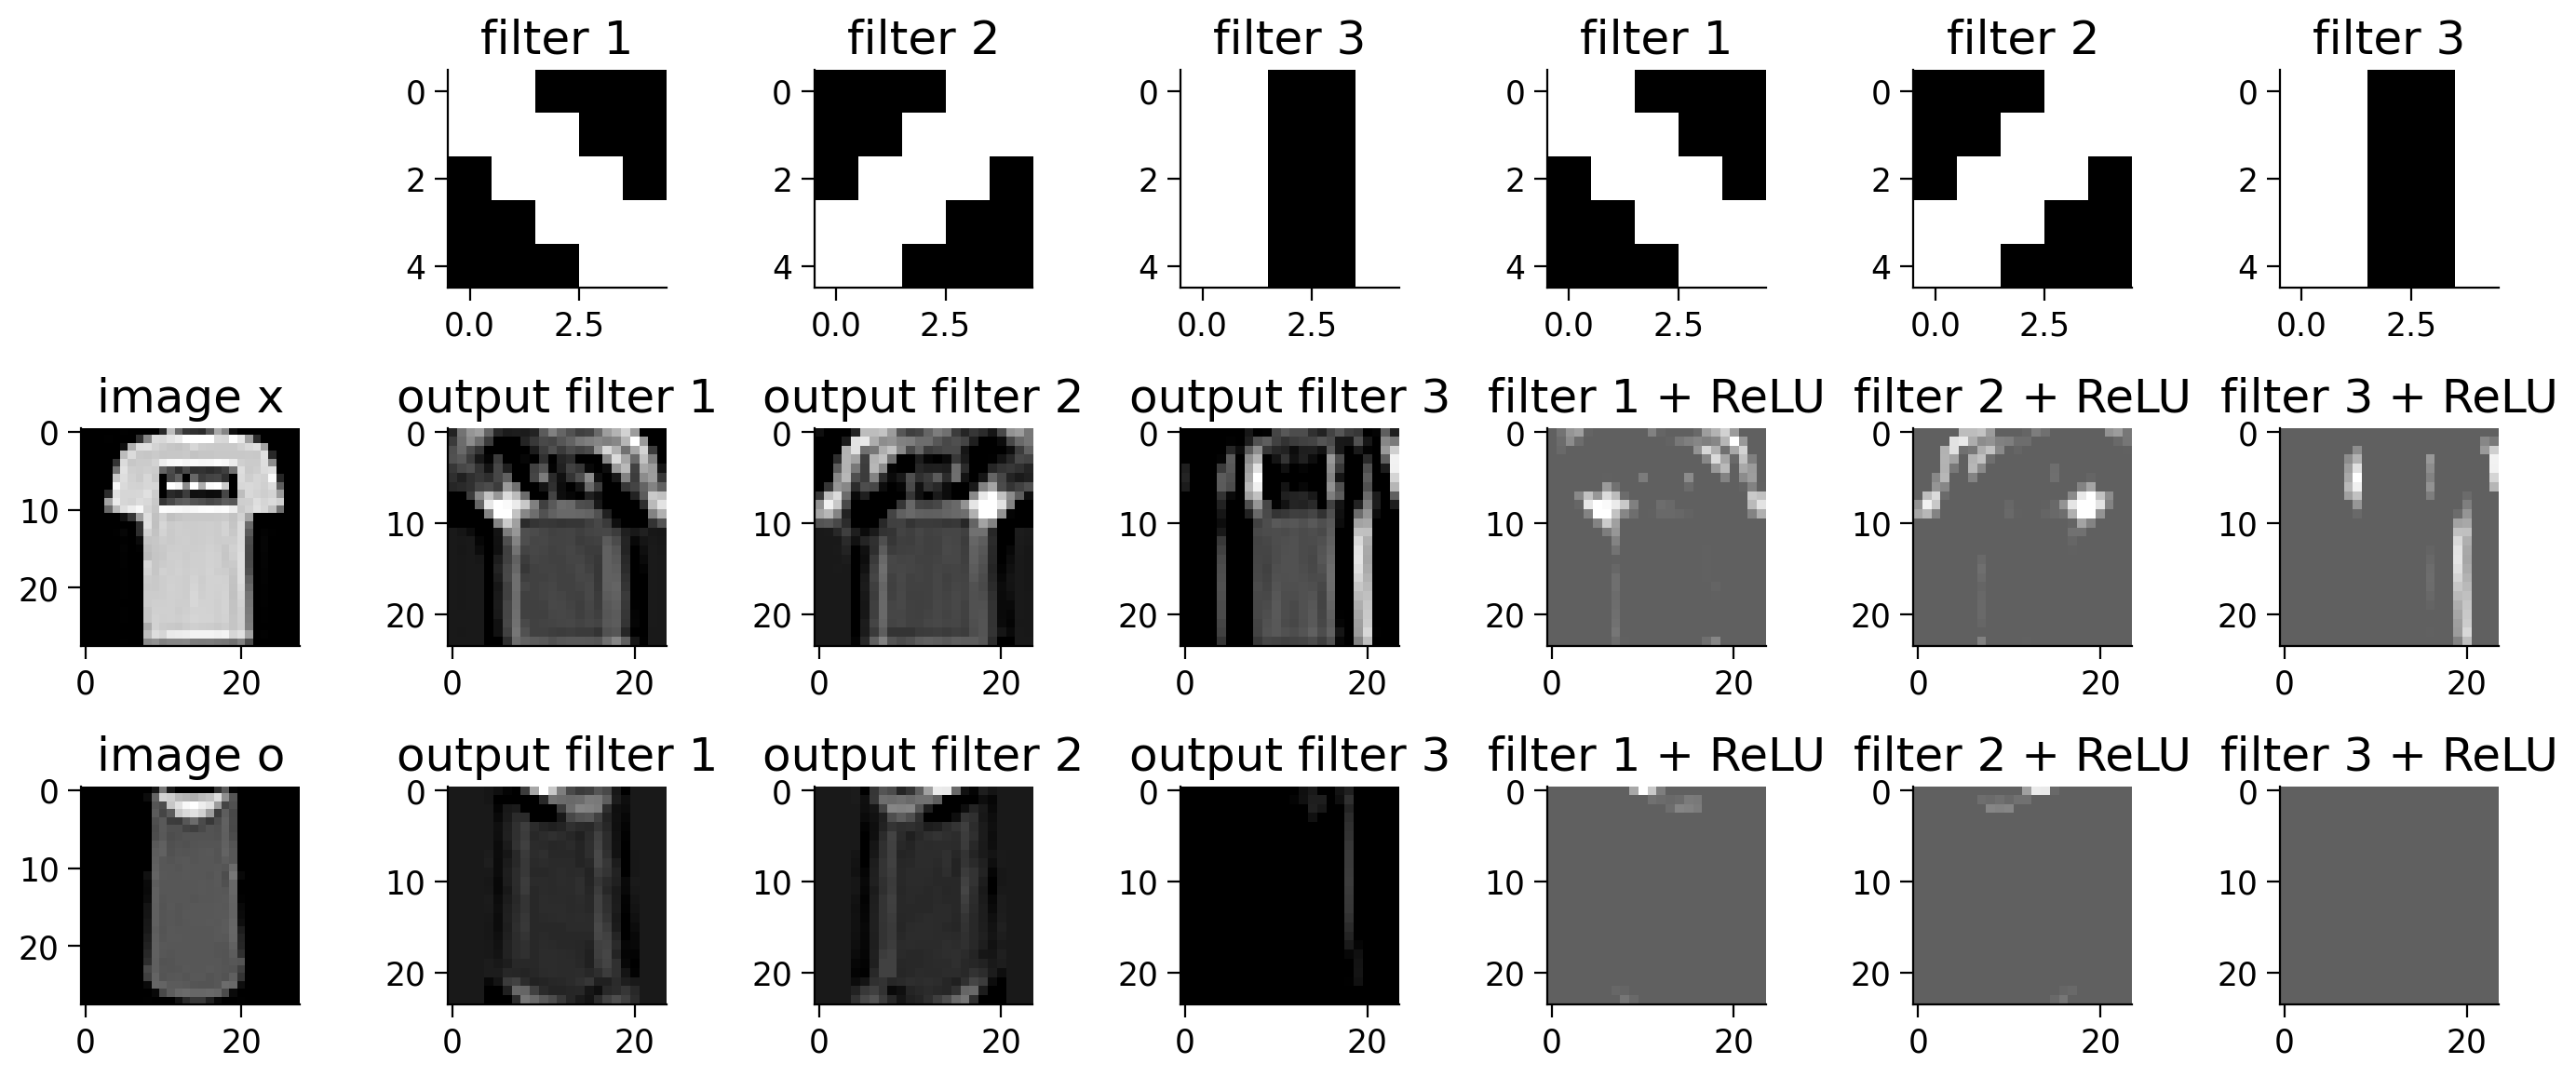

In [57]:
# @markdown *Execute this cell to view the filtered images*
fig, ((ax11, ax12, ax13, ax14, ax15, ax16, ax17),
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27),
      (ax31, ax32, ax33, ax34, ax35, ax36, ax37)) = plt.subplots(3, 4 + 3,
                                                                 figsize=(14, 6))
# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

ax15.set_title("filter 1")
ax15.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax16.set_title("filter 2")
ax16.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax17.set_title("filter 3")
ax17.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show tshirt and the filters applied to
ax21.set_title("image x")
ax21.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

ax25.set_title("filter 1 + ReLU")
ax25.imshow(output_x_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax26.set_title("filter 2 + ReLU")
ax26.imshow(output_x_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax27.set_title("filter 3 + ReLU")
ax27.imshow(output_x_relu[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show dress and the filters applied to
ax31.set_title("image o")
ax31.imshow(train_data[1][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)

ax35.set_title("filter 1 + ReLU")
ax35.imshow(output_o_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax36.set_title("filter 2 + ReLU")
ax36.imshow(output_o_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax37.set_title("filter 3 + ReLU")
ax37.imshow(output_o_relu[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

[Here](https://stats.stackexchange.com/a/226927)'s an discussion which talks about how ReLU is useful as an activation funciton.

[Here](https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks?sfb=2)'s another excellent discussion about the advantages of using ReLU.

## Section 3.3: Pooling


Pooling performs a kind of information compression that provides summary statistics for a _neighborhood_ of the input.
- In Maxpooling, we compute the maximum value of all pixels in the pooling window.
- In Avgpooling, we compute the average value of all pixels in the pooling window.

The example below shows the result of Maxpooling within the yellow pooling windows to create the red pooling output matrix.

<figure>
    <center><img src=https://developers.google.com/machine-learning/glossary/images/PoolingConvolution.svg?hl=fr width=400px>
    <figcaption>An Example of Pooling with a kernel size of 2</figcaption>
    </center>
</figure>

Remember: Pooling gives our network translational invariance by providing a summary of the values in each pooling window. Thus, a small change in the features of the underlying image won't make a huge difference to the output.

### Interactive Demo 2.3: The effect of the stride

**Important:** Change the bool variable `run_demo` to `True` by ticking the box, in order to experiment with the demo. Due to video rendering on jupyter-book, we had to remove it from the automatic execution.

The following animation depicts how changing the stride changes the output. The stride defines how much the pooling region is moved over the input matrix to produce the next output (red arrows in the animation).  Give it a try! Change the stride and see how it affects the output shape.  You can also try MaxPool or AvgPool.


In [58]:
# @markdown *Run this cell to enable the widget!*

from IPython.display import HTML

id_html = 3.3
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

### Coding Exercise 3.3: Implement MaxPooling

Let us now implement MaxPooling in PyTorch and observe the effects of Pooling on the dimension of the input image. Use a kernel of size 2 and stride of 2 for the MaxPooling layer.

In [ ]:
class Net4(nn.Module):
  """
  Neural Network instance
  """

  def __init__(self, padding=0, stride=2):
    """
    Initialise parameters of Net4

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      stride: int
        Stride

    Returns:
      Nothing
    """
    super(Net4, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                            padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    self.pool = nn.MaxPool2d(kernel_size=..., stride=...)

  def forward(self, x):
    """
    Forward Pass of Net4

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU output
    """
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    x = ... # Pass input through the convolutional layer
    ... = ... # Activate the output with ReLU
    ... = ...  # Pass through a max pool layer
    return ...


# net4 = Net4().to(DEVICE)

In [61]:
#@markdown Click here for solution
class Net4(nn.Module):
  """
  Neural Network instance
  """

  def __init__(self, padding=0, stride=2):
    """
    Initialise parameters of Net4

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      stride: int
        Stride

    Returns:
      Nothing
    """
    super(Net4, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                            padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.],
                              [1., 1., -1., -1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    """
    Forward Pass of Net4

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU output
    """
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    #raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    x = self.conv1(x) # Pass input through the convolutional layer
    x = F.relu(x) # Activate the output with ReLU
    x = self.pool(x)  # Pass through a max pool layer
    return x

## Check if your implementation is correct
net4 = Net4().to(DEVICE)

In [62]:
x_img = train_data[0][0].unsqueeze(dim=0).to(DEVICE)
output_x_pool = net4(x_img)
output_x_pool = output_x_pool.squeeze(dim=0).detach().cpu().numpy()

o_img = train_data[1][0].unsqueeze(dim=0).to(DEVICE)
output_o_pool = net4(o_img)
output_o_pool = output_o_pool.squeeze(dim=0).detach().cpu().numpy()

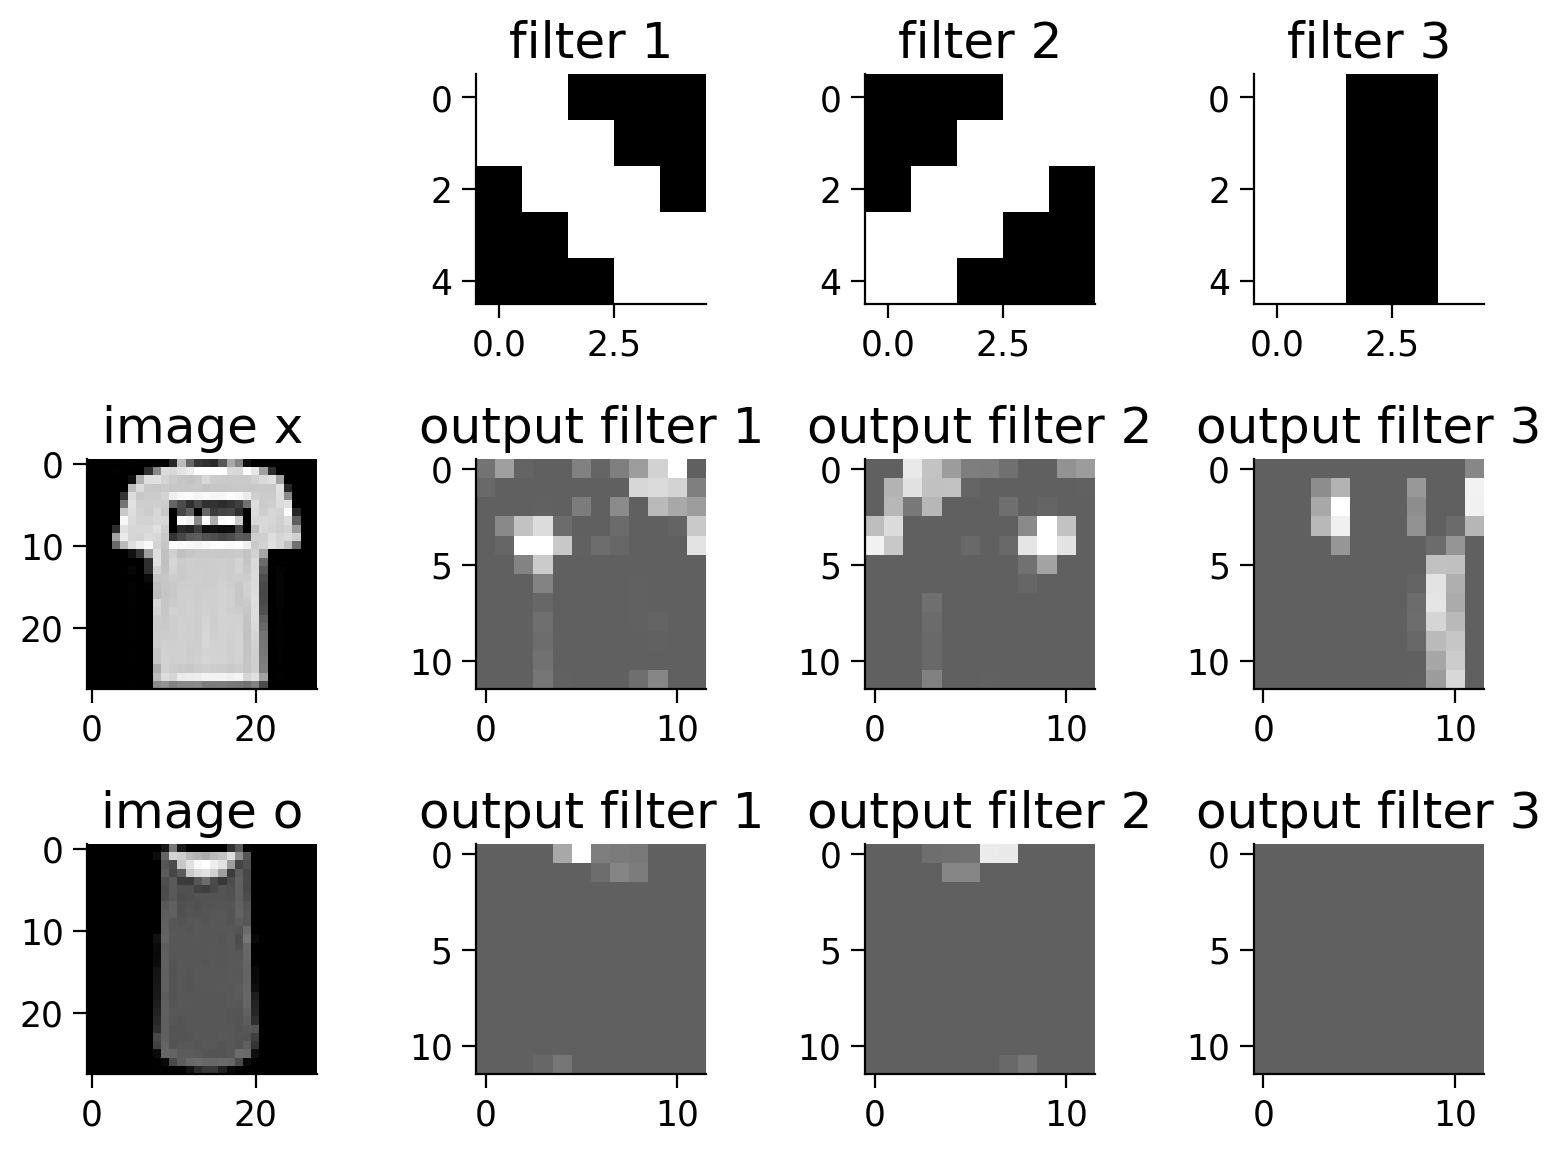

In [64]:
# @markdown *Run the cell to plot the outputs!*

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)
# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net4.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net4.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net4.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x_pool[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(train_data[1][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o_pool[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

You should observe the size of the output as being half of what you saw after the ReLU section, which is due to the Maxpool layer.

Despite the reduction in the size of the output, the important or high-level features in the output still remains intact.

---
# Section 3: Putting it all together

## Coding Exercise 3: Implement your own CNN

Let's stack up all we have learnt. Create a CNN with the following structure. <br>
- Convolution `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)`
- Convolution `nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)`
- Pool Layer `nn.MaxPool2d(kernel_size=2)`
- Fully Connected Layer `nn.Linear(in_features=9216, out_features=128)`
- Fully Connected layer `nn.Linear(in_features=128, out_features=2)`

Note: As discussed in the lecture, we would like to flatten the output from the Convolutional Layers before passing on the Linear layers, thereby converting an input of shape $[\text{BatchSize}, \text{Channels}, \text{Height}, \text{Width}]$ to $[\text{BatchSize}, \text{Channels} \times \text{Height} \times \text{Width}]$, which in this case would be from $[32, 64, 12, 12]$ (output of second convolution layer) to $[32, 64 \times 12 \times 12] = [32, 9216]$. Recall that the input images have size $[28, 28]$.

Hint: You could use `torch.flatten(x, 1)` in order to flatten the input at this stage. The $1$ means it flattens dimensions starting with dimensions 1 in order to exclude the batch dimension from the flattening.

We should also stop to think about how we get the output of the pooling layer to be $12 \times 12$. It is because first, the two `Conv2d` with a `kernel_size=3` operations cause the image to be reduced to $26 \times 26$ and the second `Conv2d` reduces it to $24 \times 24$. Finally, the `MaxPool2d` operation reduces the output size by half to $12 \times 12$.

Also, don't forget the ReLUs (use e.g., `F.ReLU`)! No need to add a ReLU after the final fully connected layer.



In [42]:
class FMNIST_Net1(nn.Module):
  """
  Convolutional Neural Network
  """

  def __init__(self, num_classes):
    """
    Initialise parameters of CNN

    Args:
      num_classes: int
        Number of classes

    Returns:
      Nothing
    """
    super(FMNIST_Net1, self).__init__()
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the required layers")
    ####################################################################

    self.conv1 = nn.Conv2d(..., ..., ...)
    self.conv2 = nn.Conv2d(..., ..., ...)
    self.fc1 = nn.Linear(..., ...)
    self.fc2 = nn.Linear(..., ...)

  def forward(self, x):
    """
    Forward pass of CNN

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through CNN
    """
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, ...)
    x = torch.flatten(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

In [62]:
#@markdown Click here for solution
class FMNIST_Net1(nn.Module):
  """
  Convolutional Neural Network
  """

  def __init__(self, num_classes):
    """
    Initialise parameters of CNN

    Args:
      num_classes: int
        Number of classes

    Returns:
      Nothing
    """
    super(FMNIST_Net1, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    """
    Forward pass of CNN

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through CNN
    """
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

In [ ]:
#@markdown Getting dataloaders
def get_data_loaders(train_dataset, validation_dataset,
                     test_dataset, seed,
                     batch_size=64):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    validation_dataset: torch.tensor
      Validation data
    batch_size: int
      Batch Size  [default: 64]
    seed: int
      Set seed for reproducibility

  Returns:
    train_loader: torch.loader
      Training Data
    test_loader: torch.loader
      Test Data
    validation_loader: torch.loader
      Validation Data
  """

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  validation_loader = DataLoader(validation_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=2,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                validation_data,
                                                                test_data, SEED)

In [66]:
def train(model, device, train_loader, validation_loader, epochs):
  """
  Training loop

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    epochs: int
      Number of epochs
    train_loader: torch.loader
      Training Set
    validation_loader: torch.loader
      Validation set

  Returns:
    Nothing
  """
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # Keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # 1. Get the model output (call the model with the data from this batch)
        output = model(data)

        # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
        #                       has collected so far with optimizer.zero_grad())
        optimizer.zero_grad()

        # 3. Get the Loss (call the loss criterion with the model's output
        #                  and the target values)
        loss = criterion(output, target)

        # 4. Calculate the gradients (do the pass backwards from the loss
        #                             with loss.backward())
        loss.backward()

        # 5. Update the weights (using the training step of the optimizer,
        #                        optimizer.step())
        optimizer.step()

        # Set loss to whatever you end up naming your variable when
        # calling criterion
        # For example, loss = criterion(output, target)
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()  # Add the loss for this batch

        # Get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      train_loss.append(running_loss / len(train_loader))  # Append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
      train_acc.append(correct / total)

      # Evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # Get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss / len(validation_loader))
      validation_acc.append(correct / total)

  return train_loss, train_acc, validation_loss, validation_acc

def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

Random seed 42 has been set.


  0%|          | 0/10 [00:00<?, ?epoch/s]

Test accuracy is: 90.5%


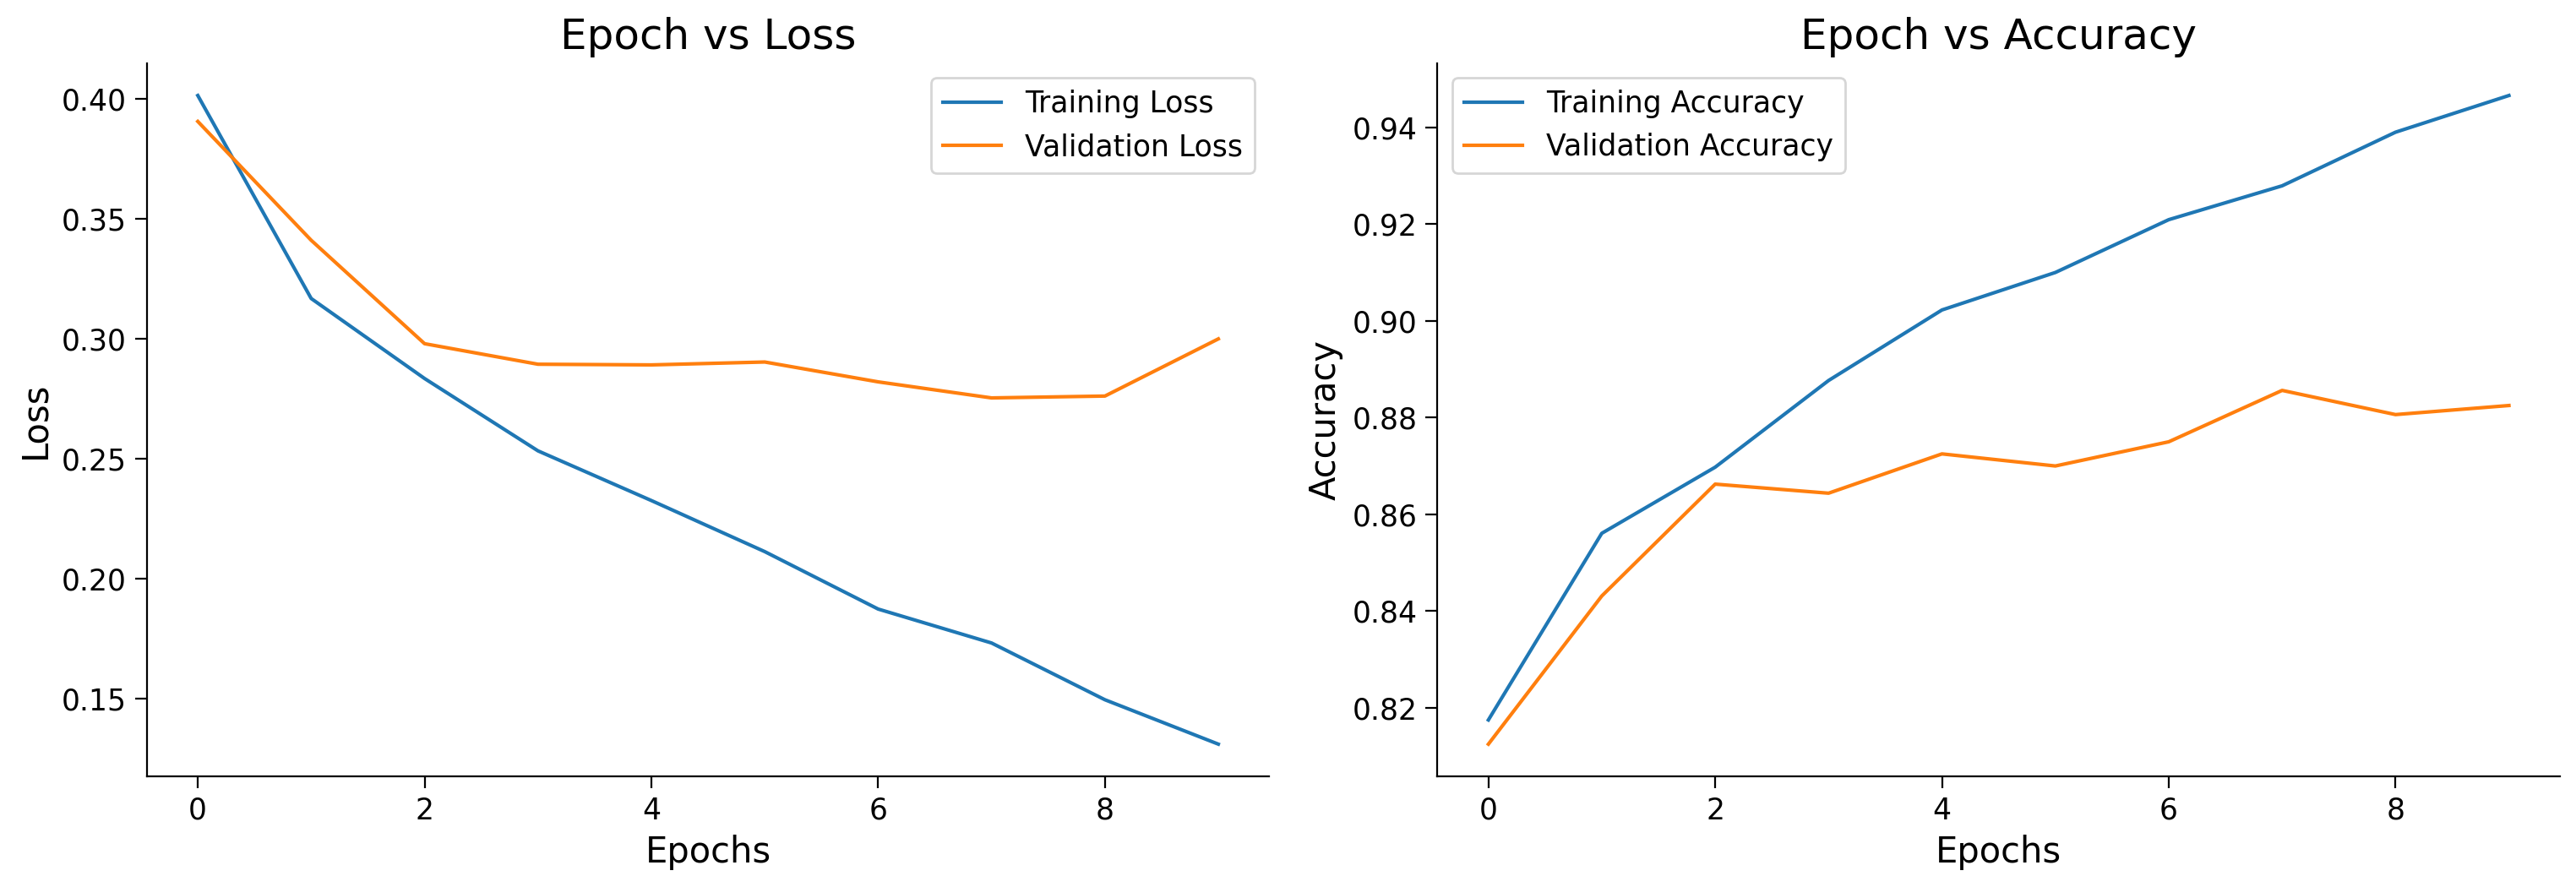

In [68]:
set_seed(SEED)

net = FMNIST_Net1(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 10)
print(f'Test accuracy is: {test(net, DEVICE, test_loader)}')

plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

You should have been able to get a test accuracy of around $90 \%$!

**Note:** We are using a softmax function here which converts a real value to a value between 0 and 1, which can be interpreted as a probability.

Input:


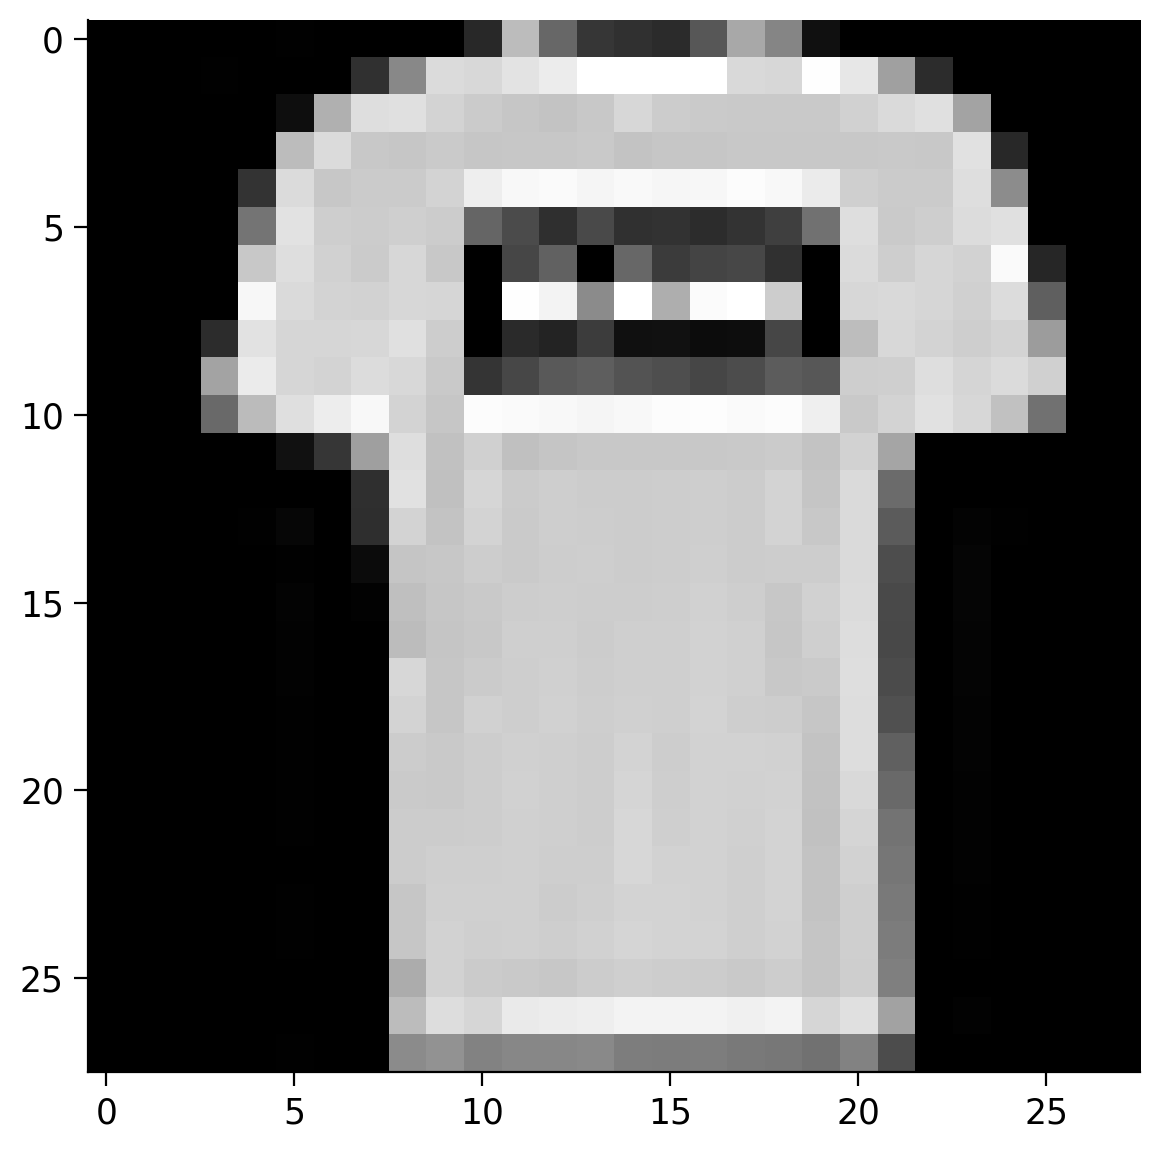


Result: tensor([[9.9998e-01, 1.6361e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being a tshirt: 0.9999836683273315
Confidence of image being a dress: 1.636118940950837e-05


In [73]:
print("Input:")
x_img = train_data[0][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(train_data[0][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = net(x_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being a tshirt:", result[0, 0].item())
print("Confidence of image being a dress:", result[0, 1].item())

Input:


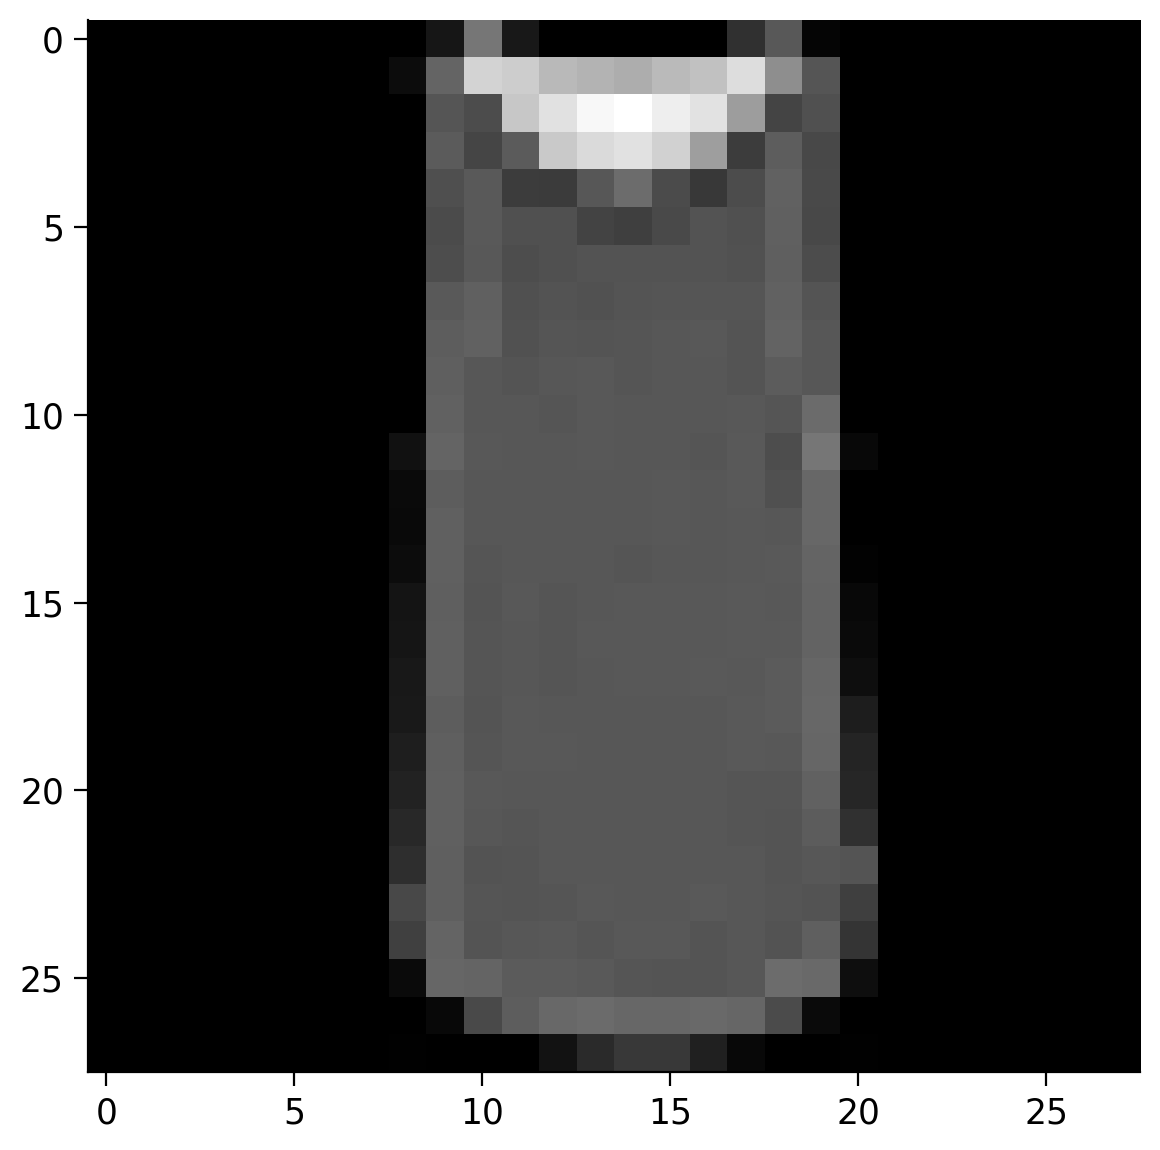


Result: tensor([[0.9104, 0.0896]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being a tshirt: 0.9103982448577881
Confidence of image being a dress: 0.0896017998456955


In [74]:
print("Input:")
o_img = train_data[1][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(train_data[1][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = net(o_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being a tshirt:", result[0, 0].item())
print("Confidence of image being a dress:", result[0, 1].item())

---
# Summary

In this Tutorial we have familiarized ouselves with CNNs. We have leaned how the convolution operation works and be applied in various images.